# Importing Libraries

In [1]:
import pandas as pd
import numpy as np
from sklearn.impute import SimpleImputer 
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn import metrics
import matplotlib.pyplot as plt
from sklearn.model_selection import StratifiedKFold                #Provides train/test indices to split data in train/test sets
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix
from sklearn.model_selection import cross_val_score
from sklearn.naive_bayes import GaussianNB
from sklearn.naive_bayes import BernoulliNB
from sklearn.svm import SVC
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2
from sklearn.model_selection import GridSearchCV
from numpy import linalg
#from sklearn import datasets
from sklearn.neighbors import kneighbors_graph
#SciPy optimize provides functions for minimizing (or maximizing) objective functions, 
#possibly subject to constraints. It includes solvers for nonlinear problems 
#(with support for both local and global optimization algorithms), 
#linear programing, constrained and nonlinear least-squares, root finding, and curve fitting.
import scipy.optimize as sco  
from itertools import cycle, islice  
#Iterator is defined as object types which contains values that can be accessed or iterated using a loop
from scipy import sparse
from scipy.optimize import minimize
from scipy.spatial.distance import cdist
from sklearn.neighbors import kneighbors_graph
#!pip install -q datascience                                         
#Package that is required by pandas profiling
#!pip install -q pandas-profiling 
import time
import warnings
warnings.filterwarnings('ignore')

In [2]:
start_time = time.time()

In [3]:
MAX_INT = 10

import math
from pprint import pprint as pp
from heapq import *

class InstanceSelection:
	"""
	A class to model pipeline for selecting representative instances
	of a given dataset

	Attributes
	-----------
	dataset_matrix : a 2-D matrix of real numbers
	nrows		   : no. of rows in the dataset 
	ncols		   : no. of columns in the dataset
	fuzzy_relation_matrix : a 2-D matrix with fuzzy relation values
	lower_approx_matrix : a 1-D list of lower approximation values of each instance
	visited			: to keep track of processed instances while finding rule covering
	representative_instances_list : a list of list of representative instances of the dataset 


	Methods
	------------
	_init_params():
		Initializes various parameters

	_get_relation_value(val_i,val_j)
		Calculates fuzzy relation value  

	_is_instance_covered(row_index_i,row_index_j)
		Tells if an instance is covered by a fuzzy rule

	compute_fuzzy_relations()
		Computes fuzzy relation matrix

	compute_lower_approximation()
		Computes Lower approximation matrix

	_init_count_rule()
		Counts the number of instances covered by each rule

	find_rule_covering()
		Finds which instances are covered by which rule and
		which rules cover which instances

	find_representative_instances()
		returns a set of list of instances which are representative of the dataset

	apply()
		calls all the functions 
	"""

	def __init__(self, dataset_matrix):
		# print("Initialising instance..")
		self.dataset_matrix = dataset_matrix
		self.ncols = len(self.dataset_matrix[0])
		self.nrows = len(self.dataset_matrix)
		self.rep_list = []
		self.representative_instances_list = []
		self._init_params()

	def _init_params(self):
		# print("Initialising parameters..")
		self.fuzzy_relation_matrix = [[MAX_INT] * self.nrows for i in range(self.nrows)]
		self.rule_instances_mapping = [[] for i in range(self.nrows)]
		self.instance_rules_mapping = [[] for i in range(self.nrows)]
		self.lower_approx_matrix = [MAX_INT for i in range(self.nrows)]
		self.visited = [False]*self.nrows

	def _get_relation_value(self, vali, valj):
		return (1 - abs(vali - valj))

	def _is_instance_covered(self, row_indi, row_indj):
		if (1 - self.fuzzy_relation_matrix[row_indi][row_indj]) < self.lower_approx_matrix[row_indi]:
			return True
		return False

	def compute_fuzzy_relations(self, attr_index_list = None):
		self._init_params()
		#print("In compute_fuzzy_relations..")
		if not attr_index_list:
			attr_index_list = set(list(range(self.ncols-1)))
		for i in range(self.nrows):
			for j in range(i,self.nrows):
				for k in attr_index_list:
					self.fuzzy_relation_matrix[i][j] = self.fuzzy_relation_matrix[j][i] = min(self.fuzzy_relation_matrix[i][j], 
								self._get_relation_value(self.dataset_matrix[i][k], self.dataset_matrix[j][k]))
					self.fuzzy_relation_matrix[i][j] = self.fuzzy_relation_matrix[j][i] = round(self.fuzzy_relation_matrix[i][j], 2)
	
	def compute_lower_approximation(self):
		#print("In compute_lower_approximation")
		for row in range(self.nrows):
			for col in range(self.nrows):
				i_label = int(self.dataset_matrix[row][self.ncols-1])
				j_label = int(self.dataset_matrix[col][self.ncols-1])

				diff_class = 0
				if(i_label != j_label):
					diff_class = 1

				self.lower_approx_matrix[row] = min(self.lower_approx_matrix[row], max(1 - self.fuzzy_relation_matrix[row][col], 1 - diff_class))

			self.lower_approx_matrix[row] = round(self.lower_approx_matrix[row], 2)


	def _init_count_rule(self):
		self.rule_instances_count = []
		for rule in range(self.nrows):
			self.rule_instances_count.append(len(self.rule_instances_mapping[rule]))

	def find_rule_covering(self):
		# print("In find_rule_covering")
		for rowi in range(self.nrows):
			for rowj in range(self.nrows):
				if self._is_instance_covered(rowi, rowj):
					self.rule_instances_mapping[rowi].append(rowj)
					self.instance_rules_mapping[rowj].append(rowi)

		self._init_count_rule()

	def find_representative_instances(self):
		if(len(self.representative_instances_list)>0):
			return

		all_done = True
		for rule, done in enumerate(self.visited):
			if not done:
				all_done = False
				break

		if all_done:
			sorted_rep_list = sorted(self.rep_list)
			if sorted_rep_list not in self.representative_instances_list:
				self.representative_instances_list.append(sorted_rep_list)
			return

		max_count = -1

		for rule, count in enumerate(self.rule_instances_count):
			if not self.visited[rule]:
				max_count = max(max_count, count)

		max_count_list = []

		for rule, count in enumerate(self.rule_instances_count):
			if count == max_count and not self.visited[rule]:
				max_count_list.append(rule)

		for rule in max_count_list:
			self.visited[rule] = True
			self.rep_list.append(rule)
			for adj_rule in self.rule_instances_mapping[rule]:
				self.visited[adj_rule] = True

			self.find_representative_instances()
			if(len(self.representative_instances_list)>0):
				return
			for adj_rule in self.rule_instances_mapping[rule]:
				self.visited[adj_rule] = False
			self.visited[rule] = False
			self.rep_list.pop()

	def apply(self):
		self.compute_fuzzy_relations()
		self.compute_lower_approximation()
		self.find_rule_covering()
		self.find_representative_instances()
		self.visited = [False]*self.nrows
	
	def debug(self):
		pass

In [4]:
class FeatureSelection:
    def __init__(self, rep_instances_set):
        self.rep_feature_set = set() 
        self.threshold = -1
        self.rep_instances_set = rep_instances_set

    def _get_instance_based_dependency_val(self, instance_selection_obj, attr_set):
        # print("ATTR SET : ",attr_set)
        #pp(instance_selection_obj.fuzzy_relation_matrix)
        instance_selection_obj.compute_fuzzy_relations(attr_set)
        #pp(instance_selection_obj.fuzzy_relation_matrix)
        instance_selection_obj.compute_lower_approximation()
        pos_sum = 0
        for instance in self.rep_instances_set:
            pos_sum += instance_selection_obj.lower_approx_matrix[instance]
        gamma_star_b = pos_sum/instance_selection_obj.nrows
        return gamma_star_b



    def find_rep_feature_set(self, instance_selection_obj):
        nattr = instance_selection_obj.ncols-1
        all_attr_set = set(list(range(nattr))) #A
        gamma_star_a = self._get_instance_based_dependency_val(instance_selection_obj, all_attr_set)
        gamma_star_a = round(gamma_star_a, 4)
        while self.threshold < gamma_star_a:
            rem_attr = all_attr_set.difference(self.rep_feature_set)
            max_gamma_star = -1
            best_attr = None
            for attr in rem_attr:
                self.rep_feature_set.add(attr)
                gamma_star = self._get_instance_based_dependency_val(instance_selection_obj, self.rep_feature_set)
                gamma_star = round(gamma_star, 4)
                # print("Gamma star : ",gamma_star,attr)
                if max_gamma_star < gamma_star and gamma_star >= self.threshold:
                    max_gamma_star = gamma_star
                    best_attr = attr
                self.rep_feature_set.discard(attr)
            if best_attr is None:
                return
            self.rep_feature_set.add(best_attr)
            # print(best_attr+1, " IS SELECTED")
            self.threshold = max_gamma_star
    
    def apply(self, instance_selection_obj):
        self.find_rep_feature_set(instance_selection_obj)

In [5]:
from pandas_profiling import ProfileReport                          # Import Pandas Profiling (To generate Univariate Analysis)
pd.set_option('display.max_columns', None)                          # Unfolding hidden features if the cardinality is high
pd.set_option('display.max_colwidth', None)                         # Unfolding the max feature width for better clearity
pd.set_option('display.max_rows', None)                             # Unfolding hidden data points if the cardinality is high
pd.set_option('mode.chained_assignment', None)                      # Removing restriction over chained assignments operations
pd.set_option('display.float_format', lambda x: '%.5f' % x)         # To suppress scientific notation over exponential values
#-------------------------------------------------------------------------------------------------------------------------------
from collections import Counter                                     # For counting hashable objects
#-------------------------------------------------------------------------------------------------------------------------------
import matplotlib.pyplot as plt                                     # Importing pyplot interface to use matplotlib
import seaborn as sns                                               # Importing seaborn library for interactive visualization
%matplotlib inline
#-------------------------------------------------------------------------------------------------------------------------------
import scipy as sp  # Importing library for scientific calculations

import sys
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import MinMaxScaler,StandardScaler
import matplotlib.pyplot as plt
import time

In [6]:
df = pd.read_excel("obesitymerge.xlsx")

In [7]:
df.sample(10)

,PatientId,Zone,State,District,Age,Gender,Waist,Height,Weight,DiabetesSelfDecl,Diafather,Diamother,Moderate,Vigorous,Dailyphysica,Hlba1c,DiabetesCalc,Diabetes,ClinicalNotes,Bmi,WcRiskScore,BmiRiskScore,BmiWcRiskScore,Waistscore,IDRSAge,IDRSFamilyH,IDRSBmi,IDRSBmiWc,IDRSPhysicalActivity,IDRS,IDRSWithBMI,IDRSWithBMIWC
6315,15663,W,Maharashtra,Nagpur,45,Male,82.00000,175,80,Diabetic,1,0,4,0,4,7.10000,Diabetic,Diabetic,KnownDiaDia,26.12245,2,3,2,0,20,10,10,10,30,60,70,70
3284,8583,NW,JammuandKashmir,Jammu,40,Female,96.00000,161,52,Normal,0,0,0,0,1,5.30000,Normal,Normal,AlwaysNormal,20.06095,4,2,2,20,20,0,0,10,30,70,50,60
455,1307,W,Rajasthan,Ajmer,31,Female,92.00000,153,62,Normal,0,0,0,0,1,5.70000,Normal,Normal,AlwaysNormal,26.48554,4,3,3,20,0,0,10,20,30,50,40,50
5127,13356,S,TamilNadu,Kanchipuram,48,Female,84.00000,147,60,Normal,0,0,1,1,2,5.20000,Normal,Normal,AlwaysNormal,27.76621,3,4,4,10,20,0,20,30,30,60,70,80
3128,8017,W,Gujarat,Navsari,20,Male,66.00000,157,45,Normal,0,0,1,0,6,5.20000,Normal,Normal,AlwaysNormal,18.25632,1,1,0,0,0,0,0,0,20,20,20,20
1562,3975,S,TamilNadu,Kanchipuram,52,Male,74.00000,173,66,Normal,0,0,2,2,1,8.20000,Diabetic,Diabetic,NewDia,22.05219,1,2,1,0,30,0,0,0,30,60,60,60
6391,15764,S,Pondicherry,Pondicherry,46,Male,110.00000,174,94,Diabetic,1,1,0,0,1,8.00000,Diabetic,Diabetic,KnownDiaDia,31.04769,5,4,4,20,20,20,20,30,30,90,90,100
4657,12218,S,TamilNadu,Kanchipuram,70,Female,92.00000,151,69,Normal,0,0,0,0,1,5.90000,Prediabetic,Normal,NewPreDia,30.26183,4,4,4,20,30,0,20,30,30,80,80,90
6685,16381,S,AndhraPradesh,Anantapur,44,Female,85.00000,155,65,Diabetic,0,0,2,2,1,5.20000,Normal,Diabetic,KnownDiaNormal,27.05515,3,3,3,10,20,0,10,20,30,60,60,70
5711,14499,E,Orissa,Balasore,45,Male,86.00000,165,80,Diabetic,1,0,1,1,2,5.00000,Normal,Diabetic,KnownDiaNormal,29.38476,2,4,3,0,20,10,20,20,30,60,80,80


In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7496 entries, 0 to 7495
Data columns (total 32 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   PatientId             7496 non-null   int64  
 1   Zone                  7496 non-null   object 
 2   State                 7496 non-null   object 
 3   District              7496 non-null   object 
 4   Age                   7496 non-null   int64  
 5   Gender                7496 non-null   object 
 6   Waist                 7495 non-null   float64
 7   Height                7496 non-null   int64  
 8   Weight                7496 non-null   int64  
 9   DiabetesSelfDecl      7496 non-null   object 
 10  Diafather             7496 non-null   int64  
 11  Diamother             7496 non-null   int64  
 12  Moderate              7496 non-null   int64  
 13  Vigorous              7496 non-null   int64  
 14  Dailyphysica          7496 non-null   int64  
 15  Hlba1c               

In [9]:
string_col = df.select_dtypes(include="object").columns
df[string_col]=df[string_col].astype("string")

In [10]:
# dropping ALL duplicate values
df.drop_duplicates(keep = False, inplace = True)

In [11]:
df.DiabetesCalc.value_counts()

Normal         3547
Diabetic       2307
Prediabetic    1642
Name: DiabetesCalc, dtype: Int64

In [12]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7496 entries, 0 to 7495
Data columns (total 32 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   PatientId             7496 non-null   int64  
 1   Zone                  7496 non-null   string 
 2   State                 7496 non-null   string 
 3   District              7496 non-null   string 
 4   Age                   7496 non-null   int64  
 5   Gender                7496 non-null   string 
 6   Waist                 7495 non-null   float64
 7   Height                7496 non-null   int64  
 8   Weight                7496 non-null   int64  
 9   DiabetesSelfDecl      7496 non-null   string 
 10  Diafather             7496 non-null   int64  
 11  Diamother             7496 non-null   int64  
 12  Moderate              7496 non-null   int64  
 13  Vigorous              7496 non-null   int64  
 14  Dailyphysica          7496 non-null   int64  
 15  Hlba1c               

# Data Preprocessing

In [13]:
df.isnull().sum()

PatientId               0
Zone                    0
State                   0
District                0
Age                     0
Gender                  0
Waist                   1
Height                  0
Weight                  0
DiabetesSelfDecl        0
Diafather               0
Diamother               0
Moderate                0
Vigorous                0
Dailyphysica            0
Hlba1c                  0
DiabetesCalc            0
Diabetes                0
ClinicalNotes           0
Bmi                     0
WcRiskScore             0
BmiRiskScore            0
BmiWcRiskScore          0
Waistscore              0
IDRSAge                 0
IDRSFamilyH             0
IDRSBmi                 0
IDRSBmiWc               0
IDRSPhysicalActivity    0
IDRS                    0
IDRSWithBMI             0
IDRSWithBMIWC           0
dtype: int64

In [14]:
df.duplicated().sum()

0

In [15]:
df.shape

(7496, 32)

In [16]:
df.describe()

,PatientId,Age,Waist,Height,Weight,Diafather,Diamother,Moderate,Vigorous,Dailyphysica,Hlba1c,Bmi,WcRiskScore,BmiRiskScore,BmiWcRiskScore,Waistscore,IDRSAge,IDRSFamilyH,IDRSBmi,IDRSBmiWc,IDRSPhysicalActivity,IDRS,IDRSWithBMI,IDRSWithBMIWC
count,7496.00000,7496.00000,7495.00000,7496.00000,7496.00000,7496.00000,7496.00000,7496.00000,7496.00000,7496.00000,7496.00000,7496.00000,7496.00000,7496.00000,7496.00000,7496.00000,7496.00000,7496.00000,7496.00000,7496.00000,7496.00000,7496.00000,7496.00000,7496.00000
mean,9508.34965,48.39221,91.20747,158.79336,65.77628,0.17129,0.15101,1.76507,1.17863,2.10112,6.45603,26.13203,3.19544,3.15155,2.89154,11.21665,22.35993,3.22305,10.97519,18.37513,27.44130,64.24093,63.99947,71.39941
std,5321.69188,11.86568,10.90646,9.53561,12.16213,0.37679,0.35809,2.07676,1.71225,1.31687,1.82042,4.59481,1.07978,0.92564,1.14609,7.91806,9.47419,5.72358,7.51047,9.88263,5.43411,15.13330,15.10690,16.63011
min,0.00000,20.00000,60.00000,121.00000,41.00000,0.00000,0.00000,0.00000,0.00000,1.00000,3.20000,12.20703,1.00000,1.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000
25%,4871.75000,40.00000,84.00000,152.00000,57.00000,0.00000,0.00000,0.00000,0.00000,1.00000,5.30000,23.11111,2.00000,3.00000,2.00000,0.00000,20.00000,0.00000,10.00000,10.00000,30.00000,60.00000,60.00000,60.00000
50%,9811.50000,48.00000,90.00000,158.00000,65.00000,0.00000,0.00000,1.00000,0.00000,2.00000,5.80000,25.71166,3.00000,3.00000,3.00000,10.00000,20.00000,0.00000,10.00000,20.00000,30.00000,70.00000,70.00000,70.00000
75%,14394.25000,58.00000,98.00000,165.00000,73.00000,0.00000,0.00000,3.00000,2.00000,3.00000,6.80000,28.62147,4.00000,4.00000,4.00000,20.00000,30.00000,10.00000,20.00000,30.00000,30.00000,70.00000,70.00000,80.00000
max,17872.00000,85.00000,150.00000,194.00000,168.00000,1.00000,1.00000,6.00000,6.00000,6.00000,15.80000,66.22230,5.00000,5.00000,5.00000,20.00000,30.00000,20.00000,20.00000,30.00000,30.00000,100.00000,100.00000,110.00000


In [17]:
df=df.drop(['PatientId', 'Zone', 'State', 'District'],axis=1)

In [18]:
df.replace([np.inf, -np.inf], np.nan, inplace=True)

In [19]:
df = df.dropna(axis=0)

In [20]:
from sklearn.preprocessing import LabelEncoder
cols = ['Gender', 'DiabetesSelfDecl', 'DiabetesCalc','Diabetes', 'ClinicalNotes', 'WcRiskScore', 'BmiRiskScore','BmiWcRiskScore', 'Waistscore', 'IDRSAge', 'IDRSFamilyH', 'IDRSBmi','IDRSBmiWc', 'IDRSPhysicalActivity', 'IDRS', 'IDRSWithBMI',
       'IDRSWithBMIWC']
df[cols] = df[cols].apply(LabelEncoder().fit_transform)
df.head()

,Age,Gender,Waist,Height,Weight,DiabetesSelfDecl,Diafather,Diamother,Moderate,Vigorous,Dailyphysica,Hlba1c,DiabetesCalc,Diabetes,ClinicalNotes,Bmi,WcRiskScore,BmiRiskScore,BmiWcRiskScore,Waistscore,IDRSAge,IDRSFamilyH,IDRSBmi,IDRSBmiWc,IDRSPhysicalActivity,IDRS,IDRSWithBMI,IDRSWithBMIWC
0,35,0,70.00000,157,47,1,0,0,0,0,3,4.90000,1,1,0,19.06771,1,1,1,0,1,0,0,0,2,5,5,5
1,38,0,81.00000,145,65,1,1,0,0,3,1,5.30000,1,1,0,30.91558,2,3,4,1,1,1,2,3,2,7,8,9
2,42,0,102.00000,159,68,1,1,1,0,0,2,5.00000,1,1,0,26.89767,4,2,3,2,1,2,1,2,2,9,8,9
3,37,0,76.00000,142,44,1,1,0,2,3,2,5.40000,1,1,0,21.82107,1,1,1,0,1,1,0,0,2,6,6,6
4,47,1,87.00000,160,60,1,1,0,2,3,3,12.60000,0,0,4,23.43750,1,2,2,0,1,1,1,1,2,6,7,7


In [21]:
x=df.drop(['DiabetesCalc','ClinicalNotes', 'Diabetes'],axis=1)
y=df['DiabetesCalc']
z=df['Diabetes']
x1= df['ClinicalNotes']

In [22]:
data=pd.concat(objs=[x,y],axis=1)

In [23]:
data = np.asarray(data)
time_taken = {}

In [24]:
MAX_ITERATIONS = round(len(data)/10)

for size in range(MAX_ITERATIONS-1,MAX_ITERATIONS):
    np.random.shuffle(data)
    test_data = data[:size]
    
    start_time1 = time.time()
    InstanceSelector = InstanceSelection(test_data)
    InstanceSelector.apply()
    end_time1 = time.time()
    algo1_time = end_time1-start_time1

    start_time2 = time.time()
    feature_selection_obj = FeatureSelection(InstanceSelector.representative_instances_list[0])
    feature_selection_obj.apply(InstanceSelector)
    end_time2 = time.time()

    representative_instances = InstanceSelector.representative_instances_list
    feature_set = list(feature_selection_obj.rep_feature_set)

In [25]:
X_train,X_test,y_train,y_test = train_test_split(data[:,feature_set],data[:,-1],test_size=0.2)

In [26]:
in_dim = data[:,feature_set].shape[1]

In [27]:
in_dim

5

In [28]:
from sklearn.model_selection import GridSearchCV, KFold
from keras.models import Sequential
from keras.layers import Dense,Dropout
from keras.wrappers.scikit_learn import KerasClassifier
from tensorflow.keras.optimizers import Adam

In [29]:
from imblearn.over_sampling import SMOTE
smote=SMOTE("minority")
X_train,y_train=smote.fit_resample(X_train,y_train)

In [30]:
from sklearn.preprocessing import StandardScaler
sc = StandardScaler()
X_train = sc.fit_transform(X_train)
X_test = sc.transform(X_test)

In [31]:
# Define a random seed
seed = 6
np.random.seed(seed)

# Start defining the model
def create_model():    
    model = Sequential()
    model.add(Dense(8, input_dim = in_dim, kernel_initializer='normal', activation='relu'))
    #model.add(Dropout(0.2))
    model.add(Dense(20, input_dim = 8, kernel_initializer='normal', activation='relu'))
    #model.add(Dense(24, input_dim = 12, kernel_initializer='normal', activation='relu'))
    model.add(Dense(8, input_dim = 20, kernel_initializer='normal', activation='relu'))
    #model.add(Dropout(0.2))
    model.add(Dense(1, activation='sigmoid'))
    
    # compile the model
    adam = Adam(lr = 0.0034) # initial value 0.01
    model.compile(loss = 'binary_crossentropy', optimizer = adam, metrics = ['accuracy'])
    return model

# create the model
model = KerasClassifier(build_fn = create_model, verbose = 1)

# define the grid search parameters
batch_size = [10, 20, 40]
epochs = [10, 50, 100]

# make a dictionary of the grid search parameters
param_grid = dict(batch_size=batch_size, epochs=epochs)



In [32]:
# build and fit the GridSearchCV
grid = GridSearchCV(estimator = model, param_grid = param_grid, cv = KFold(), verbose = 10, return_train_score=True)
#grid_results = grid.fit(X_train, y_train)
grid_results = grid.fit(X_train, y_train)

Fitting 5 folds for each of 9 candidates, totalling 45 fits
[CV 1/5; 1/9] START batch_size=10, epochs=10....................................
Epoch 1/10
600/600 [==============================] - 2s 2ms/step - loss: -2299.7915 - accuracy: 0.4591
Epoch 2/10
600/600 [==============================] - 1s 2ms/step - loss: -75055.1328 - accuracy: 0.4895
Epoch 3/10
600/600 [==============================] - 1s 2ms/step - loss: -459727.9062 - accuracy: 0.4910
Epoch 4/10
600/600 [==============================] - 2s 3ms/step - loss: -1477382.3750 - accuracy: 0.4918
Epoch 5/10
600/600 [==============================] - 2s 3ms/step - loss: -3441360.7500 - accuracy: 0.4908
Epoch 6/10
600/600 [==============================] - 2s 3ms/step - loss: -6615409.0000 - accuracy: 0.4913
Epoch 7/10
600/600 [==============================] - 2s 3ms/step - loss: -11323348.0000 - accuracy: 0.4917
Epoch 8/10
600/600 [==============================] - 2s 3ms/step - loss: -17844144.0000 - accuracy: 0.4908
Epoch 9

600/600 [==============================] - 2s 3ms/step - loss: -106902928.0000 - accuracy: 0.4788
Epoch 9/50
600/600 [==============================] - 2s 3ms/step - loss: -158764784.0000 - accuracy: 0.4786
Epoch 10/50
600/600 [==============================] - 2s 3ms/step - loss: -225032752.0000 - accuracy: 0.4783
Epoch 11/50
600/600 [==============================] - 2s 3ms/step - loss: -307748000.0000 - accuracy: 0.4788
Epoch 12/50
600/600 [==============================] - 2s 3ms/step - loss: -408609952.0000 - accuracy: 0.4788
Epoch 13/50
600/600 [==============================] - 2s 3ms/step - loss: -529981664.0000 - accuracy: 0.4790
Epoch 14/50
600/600 [==============================] - 2s 3ms/step - loss: -673918464.0000 - accuracy: 0.4785
Epoch 15/50
600/600 [==============================] - 2s 3ms/step - loss: -843066752.0000 - accuracy: 0.4791
Epoch 16/50
600/600 [==============================] - 2s 3ms/step - loss: -1038346240.0000 - accuracy: 0.4786
Epoch 17/50
600/600 [=

600/600 [==============================] - 2s 3ms/step - loss: -5038637056.0000 - accuracy: 0.3495
Epoch 29/50
600/600 [==============================] - 2s 3ms/step - loss: -5662405120.0000 - accuracy: 0.3495
Epoch 30/50
600/600 [==============================] - 2s 3ms/step - loss: -6340441088.0000 - accuracy: 0.3495
Epoch 31/50
600/600 [==============================] - 2s 3ms/step - loss: -7076432896.0000 - accuracy: 0.3495
Epoch 32/50
600/600 [==============================] - 2s 3ms/step - loss: -7870158336.0000 - accuracy: 0.3495
Epoch 33/50
600/600 [==============================] - 2s 3ms/step - loss: -8723037184.0000 - accuracy: 0.3495
Epoch 34/50
600/600 [==============================] - 2s 3ms/step - loss: -9636379648.0000 - accuracy: 0.3495
Epoch 35/50
600/600 [==============================] - 2s 3ms/step - loss: -10617246720.0000 - accuracy: 0.3495
Epoch 36/50
600/600 [==============================] - 2s 3ms/step - loss: -11669452800.0000 - accuracy: 0.3495
Epoch 37/50

600/600 [==============================] - 2s 3ms/step - loss: -8679740416.0000 - accuracy: 0.4985
Epoch 49/50
600/600 [==============================] - 2s 3ms/step - loss: -9317446656.0000 - accuracy: 0.4985
Epoch 50/50
600/600 [==============================] - 1s 2ms/step - loss: -10336493568.0000 - accuracy: 0.4987
[CV 3/5; 2/9] END batch_size=10, epochs=50;, score=(train=0.499, test=0.621) total time= 1.5min
[CV 4/5; 2/9] START batch_size=10, epochs=50....................................
Epoch 1/50
600/600 [==============================] - 2s 3ms/step - loss: -9272.6064 - accuracy: 0.3536
Epoch 2/50
600/600 [==============================] - 2s 3ms/step - loss: -318852.9062 - accuracy: 0.3536
Epoch 3/50
600/600 [==============================] - 2s 3ms/step - loss: -1968294.7500 - accuracy: 0.3536
Epoch 4/50
600/600 [==============================] - 2s 3ms/step - loss: -6361018.5000 - accuracy: 0.3536
Epoch 5/50
600/600 [==============================] - 2s 3ms/step - loss: -14

600/600 [==============================] - 2s 3ms/step - loss: -139445248.0000 - accuracy: 0.5537
Epoch 16/50
600/600 [==============================] - 2s 3ms/step - loss: -172111104.0000 - accuracy: 0.5589
Epoch 17/50
600/600 [==============================] - 2s 3ms/step - loss: -209752368.0000 - accuracy: 0.5562
Epoch 18/50
600/600 [==============================] - 2s 3ms/step - loss: -252531040.0000 - accuracy: 0.5564
Epoch 19/50
600/600 [==============================] - 2s 3ms/step - loss: -300904352.0000 - accuracy: 0.5567
Epoch 20/50
600/600 [==============================] - 2s 3ms/step - loss: -355653536.0000 - accuracy: 0.5532
Epoch 21/50
600/600 [==============================] - 2s 3ms/step - loss: -417274496.0000 - accuracy: 0.5572
Epoch 22/50
600/600 [==============================] - 2s 3ms/step - loss: -485900192.0000 - accuracy: 0.5547
Epoch 23/50
600/600 [==============================] - 2s 3ms/step - loss: -561876416.0000 - accuracy: 0.5574
Epoch 24/50
600/600 [=

600/600 [==============================] - 2s 3ms/step - loss: -3235203328.0000 - accuracy: 0.4935
Epoch 36/100
600/600 [==============================] - 2s 3ms/step - loss: -3557826816.0000 - accuracy: 0.4937
Epoch 37/100
600/600 [==============================] - 2s 3ms/step - loss: -3901332992.0000 - accuracy: 0.4937
Epoch 38/100
600/600 [==============================] - 2s 3ms/step - loss: -4268499968.0000 - accuracy: 0.4935
Epoch 39/100
600/600 [==============================] - 2s 3ms/step - loss: -4658188800.0000 - accuracy: 0.4940
Epoch 40/100
600/600 [==============================] - 2s 3ms/step - loss: -5072976896.0000 - accuracy: 0.4938
Epoch 41/100
600/600 [==============================] - 2s 3ms/step - loss: -5514374144.0000 - accuracy: 0.4937
Epoch 42/100
600/600 [==============================] - 2s 3ms/step - loss: -5982205952.0000 - accuracy: 0.4935
Epoch 43/100
600/600 [==============================] - 2s 3ms/step - loss: -6477335552.0000 - accuracy: 0.4937
Epoch

600/600 [==============================] - 2s 3ms/step - loss: -5315054.5000 - accuracy: 0.4806
Epoch 5/100
600/600 [==============================] - 2s 3ms/step - loss: -12389263.0000 - accuracy: 0.4801
Epoch 6/100
600/600 [==============================] - 2s 3ms/step - loss: -23979754.0000 - accuracy: 0.4805
Epoch 7/100
600/600 [==============================] - 2s 3ms/step - loss: -41121876.0000 - accuracy: 0.4805
Epoch 8/100
600/600 [==============================] - 2s 3ms/step - loss: -64870188.0000 - accuracy: 0.4805
Epoch 9/100
600/600 [==============================] - 2s 3ms/step - loss: -96417104.0000 - accuracy: 0.4805
Epoch 10/100
600/600 [==============================] - 2s 3ms/step - loss: -136608176.0000 - accuracy: 0.4800
Epoch 11/100
600/600 [==============================] - 2s 3ms/step - loss: -186688416.0000 - accuracy: 0.4805
Epoch 12/100
600/600 [==============================] - 2s 3ms/step - loss: -247918992.0000 - accuracy: 0.4801
Epoch 13/100
600/600 [====

600/600 [==============================] - 2s 3ms/step - loss: -126169186304.0000 - accuracy: 0.4803
Epoch 78/100
600/600 [==============================] - 2s 3ms/step - loss: -132076437504.0000 - accuracy: 0.4800
Epoch 79/100
600/600 [==============================] - 2s 3ms/step - loss: -138220453888.0000 - accuracy: 0.4801
Epoch 80/100
600/600 [==============================] - 2s 3ms/step - loss: -144592044032.0000 - accuracy: 0.4800
Epoch 81/100
600/600 [==============================] - 2s 3ms/step - loss: -151147855872.0000 - accuracy: 0.4800
Epoch 82/100
600/600 [==============================] - 2s 3ms/step - loss: -157899259904.0000 - accuracy: 0.4800
Epoch 83/100
600/600 [==============================] - 2s 3ms/step - loss: -164851122176.0000 - accuracy: 0.4800
Epoch 84/100
600/600 [==============================] - 2s 3ms/step - loss: -171998494720.0000 - accuracy: 0.4800
Epoch 85/100
600/600 [==============================] - 2s 3ms/step - loss: -179384205312.0000 - accu

600/600 [==============================] - 2s 3ms/step - loss: -5037614592.0000 - accuracy: 0.4897
Epoch 48/100
600/600 [==============================] - 2s 3ms/step - loss: -5415778304.0000 - accuracy: 0.4897
Epoch 49/100
600/600 [==============================] - 2s 3ms/step - loss: -5814574080.0000 - accuracy: 0.4897
Epoch 50/100
600/600 [==============================] - 2s 3ms/step - loss: -6232972288.0000 - accuracy: 0.4895
Epoch 51/100
600/600 [==============================] - 2s 3ms/step - loss: -6671915520.0000 - accuracy: 0.4897
Epoch 52/100
600/600 [==============================] - 2s 3ms/step - loss: -7133977088.0000 - accuracy: 0.4897
Epoch 53/100
600/600 [==============================] - 2s 3ms/step - loss: -7616987136.0000 - accuracy: 0.4897
Epoch 54/100
600/600 [==============================] - 2s 3ms/step - loss: -8125096448.0000 - accuracy: 0.4897
Epoch 55/100
600/600 [==============================] - 2s 3ms/step - loss: -8659232768.0000 - accuracy: 0.4897
Epoch

600/600 [==============================] - 2s 3ms/step - loss: -1405555456.0000 - accuracy: 0.3536
Epoch 17/100
600/600 [==============================] - 2s 3ms/step - loss: -1709518336.0000 - accuracy: 0.3536
Epoch 18/100
600/600 [==============================] - 2s 3ms/step - loss: -2059521920.0000 - accuracy: 0.3536
Epoch 19/100
600/600 [==============================] - 2s 3ms/step - loss: -2455024640.0000 - accuracy: 0.3536
Epoch 20/100
600/600 [==============================] - 2s 3ms/step - loss: -2901723648.0000 - accuracy: 0.3536
Epoch 21/100
600/600 [==============================] - 2s 3ms/step - loss: -3402845184.0000 - accuracy: 0.3536
Epoch 22/100
600/600 [==============================] - 2s 3ms/step - loss: -3962699008.0000 - accuracy: 0.3536
Epoch 23/100
600/600 [==============================] - 2s 3ms/step - loss: -4583461888.0000 - accuracy: 0.3536
Epoch 24/100
600/600 [==============================] - 2s 3ms/step - loss: -5269939712.0000 - accuracy: 0.3536
Epoch

600/600 [==============================] - 2s 3ms/step - loss: -450683469824.0000 - accuracy: 0.3536
Epoch 89/100
600/600 [==============================] - 2s 3ms/step - loss: -469426274304.0000 - accuracy: 0.3536
Epoch 90/100
600/600 [==============================] - 2s 3ms/step - loss: -488679997440.0000 - accuracy: 0.3536
Epoch 91/100
600/600 [==============================] - 2s 3ms/step - loss: -508440018944.0000 - accuracy: 0.3536
Epoch 92/100
600/600 [==============================] - 2s 3ms/step - loss: -528804708352.0000 - accuracy: 0.3536
Epoch 93/100
600/600 [==============================] - 2s 3ms/step - loss: -549778423808.0000 - accuracy: 0.3536
Epoch 94/100
600/600 [==============================] - 2s 3ms/step - loss: -571291598848.0000 - accuracy: 0.3536
Epoch 95/100
600/600 [==============================] - 2s 3ms/step - loss: -593368186880.0000 - accuracy: 0.3536
Epoch 96/100
600/600 [==============================] - 2s 3ms/step - loss: -615969521664.0000 - accu

600/600 [==============================] - 2s 3ms/step - loss: -8365683712.0000 - accuracy: 0.6761
Epoch 59/100
600/600 [==============================] - 2s 3ms/step - loss: -8885854208.0000 - accuracy: 0.6761
Epoch 60/100
600/600 [==============================] - 2s 3ms/step - loss: -9430010880.0000 - accuracy: 0.6759
Epoch 61/100
600/600 [==============================] - 2s 3ms/step - loss: -9994625024.0000 - accuracy: 0.6759
Epoch 62/100
600/600 [==============================] - 2s 3ms/step - loss: -10581804032.0000 - accuracy: 0.6759
Epoch 63/100
600/600 [==============================] - 2s 3ms/step - loss: -11192135680.0000 - accuracy: 0.6759
Epoch 64/100
600/600 [==============================] - 2s 3ms/step - loss: -11828900864.0000 - accuracy: 0.6759
Epoch 65/100
600/600 [==============================] - 2s 3ms/step - loss: -12487926784.0000 - accuracy: 0.6759
Epoch 66/100
600/600 [==============================] - 2s 3ms/step - loss: -13174572032.0000 - accuracy: 0.6759


300/300 [==============================] - 1s 3ms/step - loss: -29405.6875 - accuracy: 0.4778
Epoch 3/10
300/300 [==============================] - 1s 3ms/step - loss: -211013.8906 - accuracy: 0.4833
Epoch 4/10
300/300 [==============================] - 1s 3ms/step - loss: -766987.0000 - accuracy: 0.4858
Epoch 5/10
300/300 [==============================] - 1s 3ms/step - loss: -1966556.1250 - accuracy: 0.4866
Epoch 6/10
300/300 [==============================] - 1s 3ms/step - loss: -4105161.0000 - accuracy: 0.4871
Epoch 7/10
300/300 [==============================] - 1s 3ms/step - loss: -7415271.5000 - accuracy: 0.4870
Epoch 8/10
300/300 [==============================] - 1s 3ms/step - loss: -12185145.0000 - accuracy: 0.4875
Epoch 9/10
300/300 [==============================] - 1s 3ms/step - loss: -18748392.0000 - accuracy: 0.4871
Epoch 10/10
300/300 [==============================] - 1s 2ms/step - loss: -32279986.0000 - accuracy: 0.4877
[CV 3/5; 4/9] END batch_size=20, epochs=10;, sco

300/300 [==============================] - 1s 3ms/step - loss: -1772619776.0000 - accuracy: 0.4781
Epoch 38/50
300/300 [==============================] - 1s 3ms/step - loss: -1931053696.0000 - accuracy: 0.4781
Epoch 39/50
300/300 [==============================] - 1s 3ms/step - loss: -2099249664.0000 - accuracy: 0.4781
Epoch 40/50
300/300 [==============================] - 1s 3ms/step - loss: -2277165568.0000 - accuracy: 0.4781
Epoch 41/50
300/300 [==============================] - 1s 3ms/step - loss: -2465499392.0000 - accuracy: 0.4781
Epoch 42/50
300/300 [==============================] - 1s 3ms/step - loss: -2664704768.0000 - accuracy: 0.4781
Epoch 43/50
300/300 [==============================] - 1s 3ms/step - loss: -2875412224.0000 - accuracy: 0.4781
Epoch 44/50
300/300 [==============================] - 1s 3ms/step - loss: -3096913152.0000 - accuracy: 0.4780
Epoch 45/50
300/300 [==============================] - 1s 3ms/step - loss: -3329871360.0000 - accuracy: 0.4781
Epoch 46/50
3

300/300 [==============================] - 1s 3ms/step - loss: -1732890.3750 - accuracy: 0.4960
Epoch 6/50
300/300 [==============================] - 1s 3ms/step - loss: -3577265.5000 - accuracy: 0.4957
Epoch 7/50
300/300 [==============================] - 1s 3ms/step - loss: -6459945.5000 - accuracy: 0.4960
Epoch 8/50
300/300 [==============================] - 1s 3ms/step - loss: -10610520.0000 - accuracy: 0.4953
Epoch 9/50
300/300 [==============================] - 1s 3ms/step - loss: -16289456.0000 - accuracy: 0.4960
Epoch 10/50
300/300 [==============================] - 1s 3ms/step - loss: -23652600.0000 - accuracy: 0.4953
Epoch 11/50
300/300 [==============================] - 1s 3ms/step - loss: -32939688.0000 - accuracy: 0.4963
Epoch 12/50
300/300 [==============================] - 1s 3ms/step - loss: -44348492.0000 - accuracy: 0.4958
Epoch 13/50
300/300 [==============================] - 1s 3ms/step - loss: -58011732.0000 - accuracy: 0.4957
Epoch 14/50
300/300 [=================

300/300 [==============================] - 1s 3ms/step - loss: -162463104.0000 - accuracy: 0.3536
Epoch 27/50
300/300 [==============================] - 1s 3ms/step - loss: -183311632.0000 - accuracy: 0.3536
Epoch 28/50
300/300 [==============================] - 1s 3ms/step - loss: -205939552.0000 - accuracy: 0.3536
Epoch 29/50
300/300 [==============================] - 1s 3ms/step - loss: -230364592.0000 - accuracy: 0.3536
Epoch 30/50
300/300 [==============================] - 1s 3ms/step - loss: -256679840.0000 - accuracy: 0.3536
Epoch 31/50
300/300 [==============================] - 1s 3ms/step - loss: -285059360.0000 - accuracy: 0.3536
Epoch 32/50
300/300 [==============================] - 1s 3ms/step - loss: -315492192.0000 - accuracy: 0.3536
Epoch 33/50
300/300 [==============================] - 1s 3ms/step - loss: -348078400.0000 - accuracy: 0.3536
Epoch 34/50
300/300 [==============================] - 1s 3ms/step - loss: -382942208.0000 - accuracy: 0.3536
Epoch 35/50
300/300 [=

300/300 [==============================] - 1s 3ms/step - loss: -774310208.0000 - accuracy: 0.6814
Epoch 48/50
300/300 [==============================] - 1s 3ms/step - loss: -829126464.0000 - accuracy: 0.6814
Epoch 49/50
300/300 [==============================] - 1s 3ms/step - loss: -886683008.0000 - accuracy: 0.6814
Epoch 50/50
300/300 [==============================] - 1s 2ms/step - loss: -978626688.0000 - accuracy: 0.6814
[CV 5/5; 5/9] END batch_size=20, epochs=50;, score=(train=0.681, test=0.001) total time=  46.1s
[CV 1/5; 6/9] START batch_size=20, epochs=100...................................
Epoch 1/100
300/300 [==============================] - 1s 3ms/step - loss: -315.9728 - accuracy: 0.4443
Epoch 2/100
300/300 [==============================] - 1s 3ms/step - loss: -12535.3457 - accuracy: 0.4848
Epoch 3/100
300/300 [==============================] - 1s 3ms/step - loss: -90097.7734 - accuracy: 0.4858
Epoch 4/100
300/300 [==============================] - 1s 3ms/step - loss: -319

300/300 [==============================] - 1s 3ms/step - loss: -5588802048.0000 - accuracy: 0.4883
Epoch 68/100
300/300 [==============================] - 1s 3ms/step - loss: -5871215616.0000 - accuracy: 0.4883
Epoch 69/100
300/300 [==============================] - 1s 3ms/step - loss: -6163722240.0000 - accuracy: 0.4883
Epoch 70/100
300/300 [==============================] - 1s 3ms/step - loss: -6466442752.0000 - accuracy: 0.4883
Epoch 71/100
300/300 [==============================] - 1s 3ms/step - loss: -6779568128.0000 - accuracy: 0.4883
Epoch 72/100
300/300 [==============================] - 1s 3ms/step - loss: -7103736832.0000 - accuracy: 0.4883
Epoch 73/100
300/300 [==============================] - 1s 3ms/step - loss: -7440256512.0000 - accuracy: 0.4883
Epoch 74/100
300/300 [==============================] - 1s 3ms/step - loss: -7788191744.0000 - accuracy: 0.4883
Epoch 75/100
300/300 [==============================] - 1s 3ms/step - loss: -8146558464.0000 - accuracy: 0.4883
Epoch

300/300 [==============================] - 1s 3ms/step - loss: -617673408.0000 - accuracy: 0.3495
Epoch 38/100
300/300 [==============================] - 1s 3ms/step - loss: -672982336.0000 - accuracy: 0.3495
Epoch 39/100
300/300 [==============================] - 1s 3ms/step - loss: -731564544.0000 - accuracy: 0.3495
Epoch 40/100
300/300 [==============================] - 1s 3ms/step - loss: -793502528.0000 - accuracy: 0.3495
Epoch 41/100
300/300 [==============================] - 1s 3ms/step - loss: -858990400.0000 - accuracy: 0.3495
Epoch 42/100
300/300 [==============================] - 1s 3ms/step - loss: -928257664.0000 - accuracy: 0.3495
Epoch 43/100
300/300 [==============================] - 1s 3ms/step - loss: -1001435328.0000 - accuracy: 0.3495
Epoch 44/100
300/300 [==============================] - 1s 3ms/step - loss: -1078798080.0000 - accuracy: 0.3495
Epoch 45/100
300/300 [==============================] - 1s 3ms/step - loss: -1160355712.0000 - accuracy: 0.3495
Epoch 46/10

300/300 [==============================] - 1s 3ms/step - loss: -5824393.5000 - accuracy: 0.3560
Epoch 8/100
300/300 [==============================] - 1s 3ms/step - loss: -9563848.0000 - accuracy: 0.3560
Epoch 9/100
300/300 [==============================] - 1s 3ms/step - loss: -14656485.0000 - accuracy: 0.3560
Epoch 10/100
300/300 [==============================] - 1s 3ms/step - loss: -21288480.0000 - accuracy: 0.3560
Epoch 11/100
300/300 [==============================] - 1s 3ms/step - loss: -29658922.0000 - accuracy: 0.3560
Epoch 12/100
300/300 [==============================] - 1s 3ms/step - loss: -39956648.0000 - accuracy: 0.3560
Epoch 13/100
300/300 [==============================] - 1s 3ms/step - loss: -52393304.0000 - accuracy: 0.3560
Epoch 14/100
300/300 [==============================] - 1s 3ms/step - loss: -67100956.0000 - accuracy: 0.3560
Epoch 15/100
300/300 [==============================] - 1s 3ms/step - loss: -84327480.0000 - accuracy: 0.3560
Epoch 16/100
300/300 [=====

300/300 [==============================] - 1s 3ms/step - loss: -19315165184.0000 - accuracy: 0.3560
Epoch 81/100
300/300 [==============================] - 1s 3ms/step - loss: -20139669504.0000 - accuracy: 0.3560
Epoch 82/100
300/300 [==============================] - 1s 3ms/step - loss: -20989702144.0000 - accuracy: 0.3560
Epoch 83/100
300/300 [==============================] - 1s 3ms/step - loss: -21865328640.0000 - accuracy: 0.3560
Epoch 84/100
300/300 [==============================] - 1s 3ms/step - loss: -22767710208.0000 - accuracy: 0.3560
Epoch 85/100
300/300 [==============================] - 1s 3ms/step - loss: -23697111040.0000 - accuracy: 0.3560
Epoch 86/100
300/300 [==============================] - 1s 3ms/step - loss: -24654790656.0000 - accuracy: 0.3560
Epoch 87/100
300/300 [==============================] - 1s 3ms/step - loss: -25636294656.0000 - accuracy: 0.3560
Epoch 88/100
300/300 [==============================] - 1s 3ms/step - loss: -26647990272.0000 - accuracy: 0.3

300/300 [==============================] - 1s 3ms/step - loss: -4795857408.0000 - accuracy: 0.3536
Epoch 51/100
300/300 [==============================] - 1s 3ms/step - loss: -5115176448.0000 - accuracy: 0.3536
Epoch 52/100
300/300 [==============================] - 1s 3ms/step - loss: -5449952256.0000 - accuracy: 0.3536
Epoch 53/100
300/300 [==============================] - 1s 3ms/step - loss: -5799649280.0000 - accuracy: 0.3536
Epoch 54/100
300/300 [==============================] - 1s 3ms/step - loss: -6166130176.0000 - accuracy: 0.3536
Epoch 55/100
300/300 [==============================] - 1s 3ms/step - loss: -6548075008.0000 - accuracy: 0.3536
Epoch 56/100
300/300 [==============================] - 1s 3ms/step - loss: -6947023872.0000 - accuracy: 0.3536
Epoch 57/100
300/300 [==============================] - 1s 3ms/step - loss: -7364114432.0000 - accuracy: 0.3536
Epoch 58/100
300/300 [==============================] - 1s 3ms/step - loss: -7797578752.0000 - accuracy: 0.3536
Epoch

300/300 [==============================] - 1s 3ms/step - loss: -9484438.0000 - accuracy: 0.6283
Epoch 21/100
300/300 [==============================] - 1s 3ms/step - loss: -11067886.0000 - accuracy: 0.6258
Epoch 22/100
300/300 [==============================] - 1s 3ms/step - loss: -12825552.0000 - accuracy: 0.6257
Epoch 23/100
300/300 [==============================] - 1s 3ms/step - loss: -14770604.0000 - accuracy: 0.6260
Epoch 24/100
300/300 [==============================] - 1s 3ms/step - loss: -16926614.0000 - accuracy: 0.6287
Epoch 25/100
300/300 [==============================] - 1s 3ms/step - loss: -19282020.0000 - accuracy: 0.6240
Epoch 26/100
300/300 [==============================] - 1s 3ms/step - loss: -21856578.0000 - accuracy: 0.6277
Epoch 27/100
300/300 [==============================] - 1s 3ms/step - loss: -24657912.0000 - accuracy: 0.6270
Epoch 28/100
300/300 [==============================] - 1s 3ms/step - loss: -27699454.0000 - accuracy: 0.6248
Epoch 29/100
300/300 [==

300/300 [==============================] - 1s 3ms/step - loss: -1454331776.0000 - accuracy: 0.6295
Epoch 95/100
300/300 [==============================] - 1s 3ms/step - loss: -1507947520.0000 - accuracy: 0.6275
Epoch 96/100
300/300 [==============================] - 1s 3ms/step - loss: -1562997376.0000 - accuracy: 0.6297
Epoch 97/100
300/300 [==============================] - 1s 3ms/step - loss: -1619083648.0000 - accuracy: 0.6277
Epoch 98/100
300/300 [==============================] - 1s 3ms/step - loss: -1676680960.0000 - accuracy: 0.6303
Epoch 99/100
300/300 [==============================] - 1s 3ms/step - loss: -1735713920.0000 - accuracy: 0.6295
Epoch 100/100
300/300 [==============================] - 1s 2ms/step - loss: -1827218944.0000 - accuracy: 0.6622
[CV 5/5; 6/9] END batch_size=20, epochs=100;, score=(train=0.662, test=0.001) total time= 1.5min
[CV 1/5; 7/9] START batch_size=40, epochs=10....................................
Epoch 1/10
150/150 [==============================

150/150 [==============================] - 1s 3ms/step - loss: -31.1638 - accuracy: 0.3822
Epoch 2/50
150/150 [==============================] - 0s 3ms/step - loss: -1540.1549 - accuracy: 0.4546
Epoch 3/50
150/150 [==============================] - 0s 3ms/step - loss: -13359.4004 - accuracy: 0.4636
Epoch 4/50
150/150 [==============================] - 0s 3ms/step - loss: -53820.7227 - accuracy: 0.4650
Epoch 5/50
150/150 [==============================] - 0s 3ms/step - loss: -148804.4688 - accuracy: 0.4656
Epoch 6/50
150/150 [==============================] - 0s 3ms/step - loss: -328044.5000 - accuracy: 0.4665
Epoch 7/50
150/150 [==============================] - 0s 3ms/step - loss: -624303.0000 - accuracy: 0.4665
Epoch 8/50
150/150 [==============================] - 0s 3ms/step - loss: -1072401.0000 - accuracy: 0.4675
Epoch 9/50
150/150 [==============================] - 0s 3ms/step - loss: -1708891.2500 - accuracy: 0.4673
Epoch 10/50
150/150 [==============================] - 0s 3ms/s

150/150 [==============================] - 0s 3ms/step - loss: -37363216.0000 - accuracy: 0.3495
Epoch 24/50
150/150 [==============================] - 0s 3ms/step - loss: -43098944.0000 - accuracy: 0.3495
Epoch 25/50
150/150 [==============================] - 0s 3ms/step - loss: -49390184.0000 - accuracy: 0.3495
Epoch 26/50
150/150 [==============================] - 0s 3ms/step - loss: -56273452.0000 - accuracy: 0.3495
Epoch 27/50
150/150 [==============================] - 0s 3ms/step - loss: -63755980.0000 - accuracy: 0.3495
Epoch 28/50
150/150 [==============================] - 0s 3ms/step - loss: -71887416.0000 - accuracy: 0.3495
Epoch 29/50
150/150 [==============================] - 0s 3ms/step - loss: -80647608.0000 - accuracy: 0.3495
Epoch 30/50
150/150 [==============================] - 0s 3ms/step - loss: -90102792.0000 - accuracy: 0.3495
Epoch 31/50
150/150 [==============================] - 0s 3ms/step - loss: -100271504.0000 - accuracy: 0.3495
Epoch 32/50
150/150 [=========

150/150 [==============================] - 0s 3ms/step - loss: -396727456.0000 - accuracy: 0.3560
Epoch 45/50
150/150 [==============================] - 0s 3ms/step - loss: -426002848.0000 - accuracy: 0.3560
Epoch 46/50
150/150 [==============================] - 0s 3ms/step - loss: -456748480.0000 - accuracy: 0.3560
Epoch 47/50
150/150 [==============================] - 0s 3ms/step - loss: -488922656.0000 - accuracy: 0.3560
Epoch 48/50
150/150 [==============================] - 0s 3ms/step - loss: -522577024.0000 - accuracy: 0.3560
Epoch 49/50
150/150 [==============================] - 0s 3ms/step - loss: -557798464.0000 - accuracy: 0.3560
Epoch 50/50
150/150 [==============================] - 0s 2ms/step - loss: -613827968.0000 - accuracy: 0.3560
[CV 3/5; 8/9] END batch_size=40, epochs=50;, score=(train=0.356, test=0.462) total time=  23.3s
[CV 4/5; 8/9] START batch_size=40, epochs=50....................................
Epoch 1/50
150/150 [==============================] - 1s 3ms/step

Epoch 13/50
150/150 [==============================] - 0s 3ms/step - loss: -1195079.6250 - accuracy: 0.6647
Epoch 14/50
150/150 [==============================] - 0s 3ms/step - loss: -1562798.0000 - accuracy: 0.6649
Epoch 15/50
150/150 [==============================] - 0s 3ms/step - loss: -2002247.2500 - accuracy: 0.6649
Epoch 16/50
150/150 [==============================] - 0s 3ms/step - loss: -2520268.0000 - accuracy: 0.6652
Epoch 17/50
150/150 [==============================] - 0s 3ms/step - loss: -3121609.7500 - accuracy: 0.6646
Epoch 18/50
150/150 [==============================] - 0s 3ms/step - loss: -3813112.2500 - accuracy: 0.6652
Epoch 19/50
150/150 [==============================] - 0s 3ms/step - loss: -4600078.5000 - accuracy: 0.6654
Epoch 20/50
150/150 [==============================] - 0s 3ms/step - loss: -5484706.5000 - accuracy: 0.6651
Epoch 21/50
150/150 [==============================] - 0s 3ms/step - loss: -6476985.0000 - accuracy: 0.6651
Epoch 22/50
150/150 [=======

150/150 [==============================] - 0s 3ms/step - loss: -104158480.0000 - accuracy: 0.3556
Epoch 35/100
150/150 [==============================] - 0s 3ms/step - loss: -114369208.0000 - accuracy: 0.3556
Epoch 36/100
150/150 [==============================] - 0s 3ms/step - loss: -125221688.0000 - accuracy: 0.3556
Epoch 37/100
150/150 [==============================] - 0s 3ms/step - loss: -136710032.0000 - accuracy: 0.3556
Epoch 38/100
150/150 [==============================] - 0s 3ms/step - loss: -148868240.0000 - accuracy: 0.3556
Epoch 39/100
150/150 [==============================] - 0s 3ms/step - loss: -161745840.0000 - accuracy: 0.3556
Epoch 40/100
150/150 [==============================] - 0s 3ms/step - loss: -175397200.0000 - accuracy: 0.3556
Epoch 41/100
150/150 [==============================] - 0s 3ms/step - loss: -189791712.0000 - accuracy: 0.3556
Epoch 42/100
150/150 [==============================] - 0s 3ms/step - loss: -204950672.0000 - accuracy: 0.3556
Epoch 43/100
1

150/150 [==============================] - 0s 3ms/step - loss: -36170.5391 - accuracy: 0.4589
Epoch 5/100
150/150 [==============================] - 0s 3ms/step - loss: -98903.5391 - accuracy: 0.4601
Epoch 6/100
150/150 [==============================] - 0s 3ms/step - loss: -218326.0000 - accuracy: 0.4613
Epoch 7/100
150/150 [==============================] - 0s 3ms/step - loss: -417094.1250 - accuracy: 0.4609
Epoch 8/100
150/150 [==============================] - 0s 3ms/step - loss: -719886.8125 - accuracy: 0.4613
Epoch 9/100
150/150 [==============================] - 0s 3ms/step - loss: -1152602.6250 - accuracy: 0.4616
Epoch 10/100
150/150 [==============================] - 0s 3ms/step - loss: -1739630.2500 - accuracy: 0.4616
Epoch 11/100
150/150 [==============================] - 0s 3ms/step - loss: -2507276.2500 - accuracy: 0.4623
Epoch 12/100
150/150 [==============================] - 0s 3ms/step - loss: -3480989.2500 - accuracy: 0.4621
Epoch 13/100
150/150 [======================

150/150 [==============================] - 0s 3ms/step - loss: -1743269888.0000 - accuracy: 0.4680
Epoch 79/100
150/150 [==============================] - 0s 3ms/step - loss: -1816221696.0000 - accuracy: 0.4680
Epoch 80/100
150/150 [==============================] - 0s 3ms/step - loss: -1891233024.0000 - accuracy: 0.4680
Epoch 81/100
150/150 [==============================] - 0s 3ms/step - loss: -1968189184.0000 - accuracy: 0.4680
Epoch 82/100
150/150 [==============================] - 0s 3ms/step - loss: -2047460480.0000 - accuracy: 0.4680
Epoch 83/100
150/150 [==============================] - 0s 3ms/step - loss: -2128879360.0000 - accuracy: 0.4680
Epoch 84/100
150/150 [==============================] - 0s 3ms/step - loss: -2212653056.0000 - accuracy: 0.4680
Epoch 85/100
150/150 [==============================] - 0s 3ms/step - loss: -2298620928.0000 - accuracy: 0.4680
Epoch 86/100
150/150 [==============================] - 0s 3ms/step - loss: -2386900992.0000 - accuracy: 0.4680
Epoch

150/150 [==============================] - 0s 3ms/step - loss: -523710656.0000 - accuracy: 0.3560
Epoch 49/100
150/150 [==============================] - 0s 3ms/step - loss: -559154240.0000 - accuracy: 0.3560
Epoch 50/100
150/150 [==============================] - 0s 3ms/step - loss: -596202880.0000 - accuracy: 0.3560
Epoch 51/100
150/150 [==============================] - 0s 3ms/step - loss: -634804288.0000 - accuracy: 0.3560
Epoch 52/100
150/150 [==============================] - 0s 3ms/step - loss: -675044544.0000 - accuracy: 0.3560
Epoch 53/100
150/150 [==============================] - 0s 3ms/step - loss: -717068352.0000 - accuracy: 0.3560
Epoch 54/100
150/150 [==============================] - 0s 3ms/step - loss: -760911808.0000 - accuracy: 0.3560
Epoch 55/100
150/150 [==============================] - 0s 3ms/step - loss: -806556288.0000 - accuracy: 0.3560
Epoch 56/100
150/150 [==============================] - 0s 3ms/step - loss: -853918784.0000 - accuracy: 0.3560
Epoch 57/100
1

150/150 [==============================] - 0s 3ms/step - loss: -18175250.0000 - accuracy: 0.3536
Epoch 19/100
150/150 [==============================] - 0s 3ms/step - loss: -21917820.0000 - accuracy: 0.3536
Epoch 20/100
150/150 [==============================] - 0s 3ms/step - loss: -26143636.0000 - accuracy: 0.3536
Epoch 21/100
150/150 [==============================] - 0s 3ms/step - loss: -30866252.0000 - accuracy: 0.3536
Epoch 22/100
150/150 [==============================] - 0s 3ms/step - loss: -36114988.0000 - accuracy: 0.3536
Epoch 23/100
150/150 [==============================] - 0s 3ms/step - loss: -41906960.0000 - accuracy: 0.3536
Epoch 24/100
150/150 [==============================] - 0s 3ms/step - loss: -48300424.0000 - accuracy: 0.3536
Epoch 25/100
150/150 [==============================] - 0s 3ms/step - loss: -55322032.0000 - accuracy: 0.3536
Epoch 26/100
150/150 [==============================] - 0s 3ms/step - loss: -62995956.0000 - accuracy: 0.3536
Epoch 27/100
150/150 [=

150/150 [==============================] - 0s 3ms/step - loss: -3657773056.0000 - accuracy: 0.3536
Epoch 92/100
150/150 [==============================] - 0s 3ms/step - loss: -3791238400.0000 - accuracy: 0.3536
Epoch 93/100
150/150 [==============================] - 0s 3ms/step - loss: -3928134144.0000 - accuracy: 0.3536
Epoch 94/100
150/150 [==============================] - 0s 3ms/step - loss: -4068374528.0000 - accuracy: 0.3536
Epoch 95/100
150/150 [==============================] - 0s 3ms/step - loss: -4212154880.0000 - accuracy: 0.3536
Epoch 96/100
150/150 [==============================] - 0s 3ms/step - loss: -4359401984.0000 - accuracy: 0.3536
Epoch 97/100
150/150 [==============================] - 0s 3ms/step - loss: -4510288896.0000 - accuracy: 0.3536
Epoch 98/100
150/150 [==============================] - 0s 3ms/step - loss: -4664873472.0000 - accuracy: 0.3536
Epoch 99/100
150/150 [==============================] - 0s 3ms/step - loss: -4823240704.0000 - accuracy: 0.3536
Epoch

150/150 [==============================] - 0s 3ms/step - loss: -138943216.0000 - accuracy: 0.5556
Epoch 63/100
150/150 [==============================] - 0s 3ms/step - loss: -146159264.0000 - accuracy: 0.5569
Epoch 64/100
150/150 [==============================] - 0s 3ms/step - loss: -153656288.0000 - accuracy: 0.5551
Epoch 65/100
150/150 [==============================] - 0s 3ms/step - loss: -161377504.0000 - accuracy: 0.5551
Epoch 66/100
150/150 [==============================] - 0s 3ms/step - loss: -169352480.0000 - accuracy: 0.5599
Epoch 67/100
150/150 [==============================] - 0s 3ms/step - loss: -177582400.0000 - accuracy: 0.5559
Epoch 68/100
150/150 [==============================] - 0s 3ms/step - loss: -186069056.0000 - accuracy: 0.5541
Epoch 69/100
150/150 [==============================] - 0s 3ms/step - loss: -194893920.0000 - accuracy: 0.5566
Epoch 70/100
150/150 [==============================] - 0s 3ms/step - loss: -204028816.0000 - accuracy: 0.5564
Epoch 71/100
1

749/749 [==============================] - 2s 3ms/step - loss: -7900817408.0000 - accuracy: 0.5304
Epoch 34/100
749/749 [==============================] - 2s 3ms/step - loss: -8744302592.0000 - accuracy: 0.5308
Epoch 35/100
749/749 [==============================] - 2s 3ms/step - loss: -9652278272.0000 - accuracy: 0.5304
Epoch 36/100
749/749 [==============================] - 2s 3ms/step - loss: -10630989824.0000 - accuracy: 0.5304
Epoch 37/100
749/749 [==============================] - 2s 3ms/step - loss: -11679440896.0000 - accuracy: 0.5306
Epoch 38/100
749/749 [==============================] - 2s 3ms/step - loss: -12795514880.0000 - accuracy: 0.5306
Epoch 39/100
749/749 [==============================] - 2s 3ms/step - loss: -13996640256.0000 - accuracy: 0.5307
Epoch 40/100
749/749 [==============================] - 2s 3ms/step - loss: -15282029568.0000 - accuracy: 0.5303
Epoch 41/100
749/749 [==============================] - 2s 3ms/step - loss: -16649966592.0000 - accuracy: 0.5310

In [33]:
# summarize the results
print("Best: {0}, using {1}".format(grid_results.best_score_, grid_results.best_params_))
means = grid_results.cv_results_['mean_test_score']
stds = grid_results.cv_results_['std_test_score']
params = grid_results.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print('{0} ({1}) with: {2}'.format(mean, stdev, param))

Best: 0.4821094809565693, using {'batch_size': 10, 'epochs': 100}
0.4459278939757496 (0.23318550379459216) with: {'batch_size': 10, 'epochs': 10}
0.44419225440360605 (0.23157180552288223) with: {'batch_size': 10, 'epochs': 50}
0.4821094809565693 (0.2504629493150127) with: {'batch_size': 10, 'epochs': 100}
0.4409879802260548 (0.22916537330362144) with: {'batch_size': 20, 'epochs': 10}
0.44325767741538585 (0.23083992595867556) with: {'batch_size': 20, 'epochs': 50}
0.4148197589907795 (0.21806764736571566) with: {'batch_size': 20, 'epochs': 100}
0.41281709061004224 (0.21591992896454504) with: {'batch_size': 40, 'epochs': 10}
0.4445927916560322 (0.23316487314621256) with: {'batch_size': 40, 'epochs': 50}
0.4105473993811756 (0.21737681830458208) with: {'batch_size': 40, 'epochs': 100}


In [34]:
bst_size, bst_eph = grid_results.best_params_.values()
print(bst_size, bst_eph)

10 100


Epoch 1/100
749/749 [==============================] - 3s 3ms/step - loss: -13896.7949 - accuracy: 0.3770 - val_loss: -31006.1543 - val_accuracy: 0.4817
Epoch 2/100
749/749 [==============================] - 2s 3ms/step - loss: -419385.7812 - accuracy: 0.3772 - val_loss: -452352.9062 - val_accuracy: 0.4817
Epoch 3/100
749/749 [==============================] - 2s 3ms/step - loss: -2469978.0000 - accuracy: 0.3772 - val_loss: -1933389.7500 - val_accuracy: 0.4817
Epoch 4/100
749/749 [==============================] - 2s 3ms/step - loss: -7697220.0000 - accuracy: 0.3772 - val_loss: -5133171.5000 - val_accuracy: 0.4817
Epoch 5/100
749/749 [==============================] - 2s 3ms/step - loss: -17625118.0000 - accuracy: 0.3772 - val_loss: -10729646.0000 - val_accuracy: 0.4817
Epoch 6/100
749/749 [==============================] - 2s 3ms/step - loss: -33751076.0000 - accuracy: 0.3772 - val_loss: -19308896.0000 - val_accuracy: 0.4817
Epoch 7/100
749/749 [==============================] - 2s 3m

749/749 [==============================] - 2s 3ms/step - loss: -43737542656.0000 - accuracy: 0.3772 - val_loss: -19848159232.0000 - val_accuracy: 0.4817
Epoch 52/100
749/749 [==============================] - 2s 3ms/step - loss: -46810882048.0000 - accuracy: 0.3772 - val_loss: -21224585216.0000 - val_accuracy: 0.4817
Epoch 53/100
749/749 [==============================] - 2s 3ms/step - loss: -50040303616.0000 - accuracy: 0.3772 - val_loss: -22679885824.0000 - val_accuracy: 0.4817
Epoch 54/100
749/749 [==============================] - 2s 3ms/step - loss: -53425016832.0000 - accuracy: 0.3772 - val_loss: -24195764224.0000 - val_accuracy: 0.4817
Epoch 55/100
749/749 [==============================] - 2s 3ms/step - loss: -56977547264.0000 - accuracy: 0.3772 - val_loss: -25794994176.0000 - val_accuracy: 0.4817
Epoch 56/100
749/749 [==============================] - 2s 3ms/step - loss: -60706717696.0000 - accuracy: 0.3772 - val_loss: -27466885120.0000 - val_accuracy: 0.4817
Epoch 57/100
749/

749/749 [==============================] - 2s 3ms/step - loss: -487397982208.0000 - accuracy: 0.3772 - val_loss: -217692831744.0000 - val_accuracy: 0.4817
dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


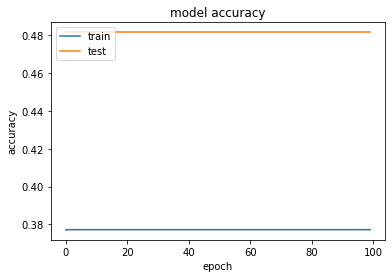

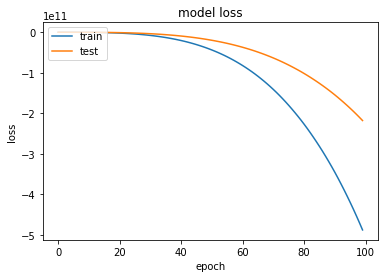

In [35]:
# call the function to fit to the data (training the network)
history= model.fit(X_train, y_train, epochs = bst_eph, batch_size=bst_size, validation_data=(X_test, y_test))

# save the model
#model.save('weights.h5')


print(history.history.keys())
# summarize history for accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [36]:
y_pred = grid.predict(X_test)

In [37]:
from sklearn.metrics import classification_report, accuracy_score

print(accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred))

0.6717811874583055
              precision    recall  f1-score   support

         0.0       1.00      0.61      0.76       466
         1.0       0.59      1.00      0.75       722
         2.0       0.00      0.00      0.00       311

    accuracy                           0.67      1499
   macro avg       0.53      0.54      0.50      1499
weighted avg       0.60      0.67      0.60      1499



Text(0.5, 15.0, 'Predicted label')

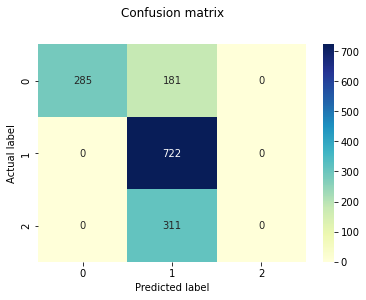

In [38]:
from sklearn import metrics
import seaborn as sns
cnf_matrix = metrics.confusion_matrix(y_test, y_pred)
p = sns.heatmap(pd.DataFrame(cnf_matrix), annot=True, cmap="YlGnBu" ,fmt='g')
plt.title('Confusion matrix', y=1.1)
plt.ylabel('Actual label')
plt.xlabel('Predicted label')

In [39]:
from sklearn.preprocessing import LabelBinarizer
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import roc_auc_score

In [40]:
def multiclass_roc_auc_score(y_test, y_pred, average="macro"):
    lb = LabelBinarizer()
    lb.fit(y_test)
    y_test = lb.transform(y_test)
    y_pred = lb.transform(y_pred)
    return roc_auc_score(y_test, y_pred, average=average)

In [41]:
print(multiclass_roc_auc_score(y_test, y_pred))

0.6630638916046642


In [42]:
# store end time
end = time.time()
time_tkn = end-start_time
print('Time taken in hours:',time_tkn/(60*60))
print('Time taken in mins:',time_tkn/(60))

Time taken in hours: 1.0005990968147913
Time taken in mins: 60.03594580888748


In [43]:
tensorflow.__version__

NameError: name 'tensorflow' is not defined